Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Rescaling

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Checking for the GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "not available")

GPU is not available


In [9]:
# check the current folder under drive
!ls /content/drive

MyDrive


In [30]:
!unzip "/content/drive/MyDrive/Melonoma_Assignmnet/CNN_assignment.zip" -d "/content/drive/MyDrive/Melonoma_Assignmnet/Datasets1"

Archive:  /content/drive/MyDrive/Melonoma_Assignmnet/CNN_assignment.zip
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Melonoma_Assignmnet/Datasets1/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
# creating training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


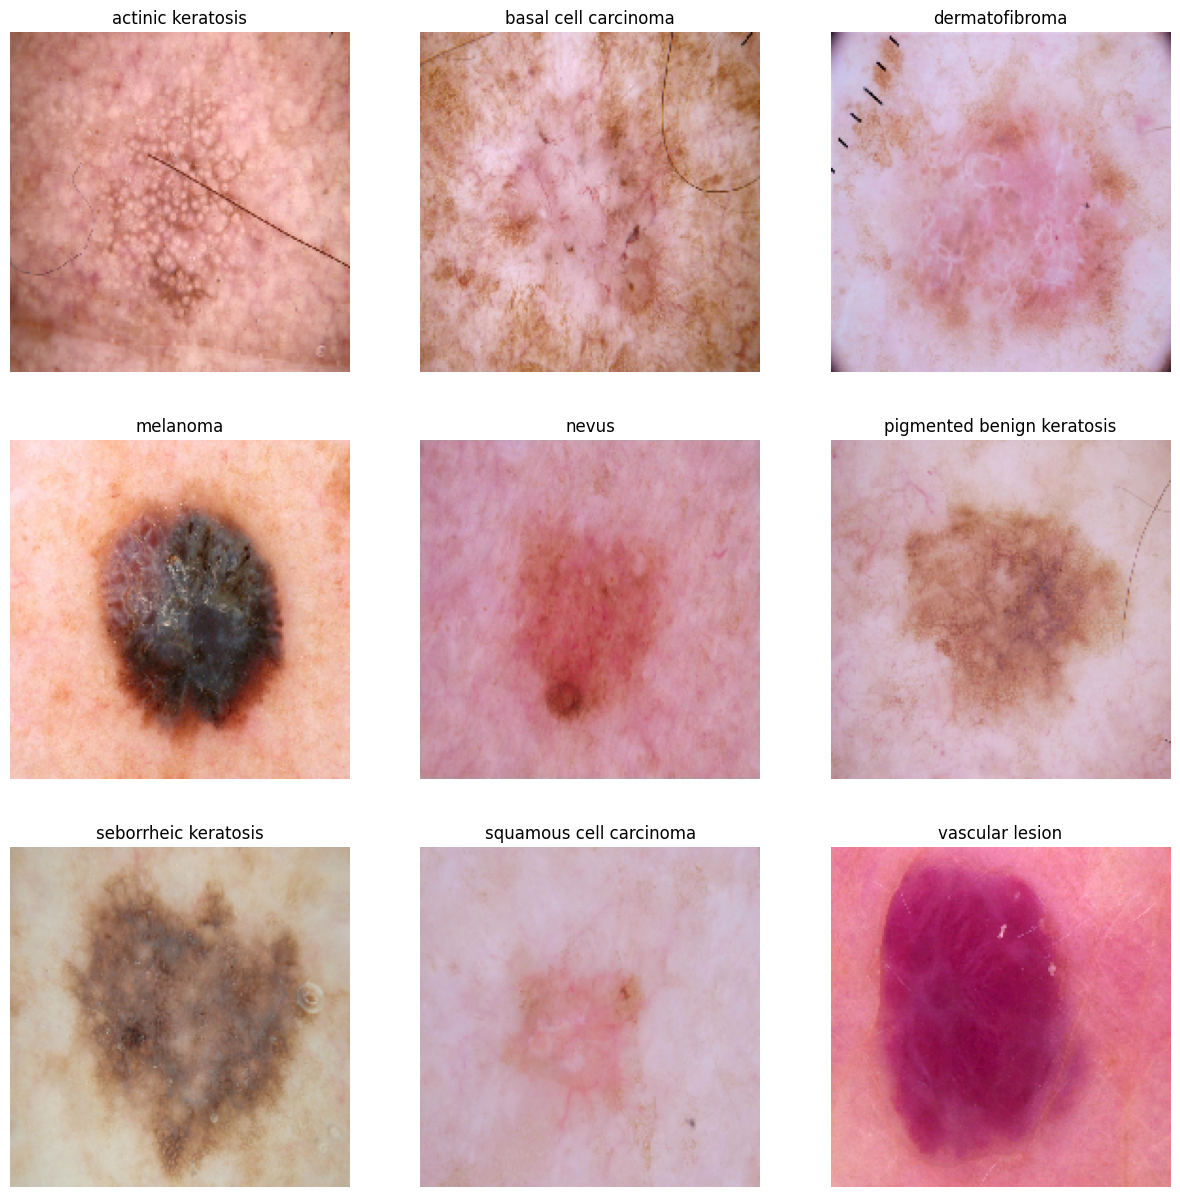

In [16]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [17]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

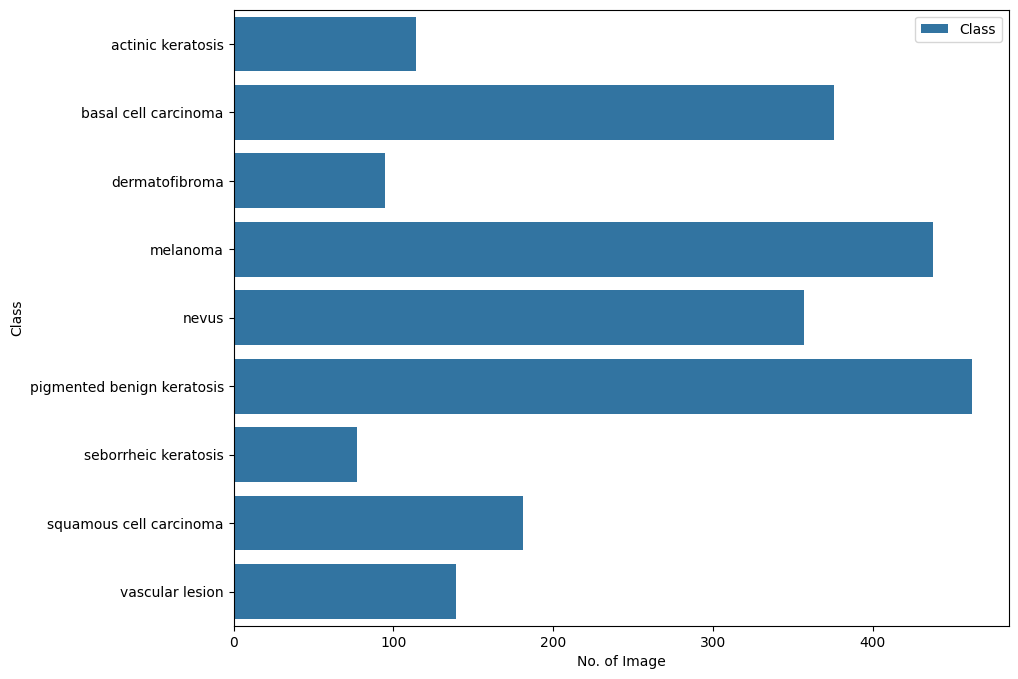

In [18]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

**MODEL1**

In [20]:
#CNN Model Architecture 1

model1 = Sequential()

model1.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# 1st Convolutional layer
model1.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

# 2nd Convolutional layer
model1.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

# 3rd Convolutional layer
model1.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model1.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model1.add(layers.Flatten())

#Dense Layer
model1.add(layers.Dense(64,activation='relu'))

#Dense Layer with softmax activation function.
model1.add(layers.Dense(len(class_names),activation='softmax'))

model1.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [23]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [25]:
epochs = 20
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.2101 - loss: 2.0621 - val_accuracy: 0.3624 - val_loss: 1.7025
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3952 - loss: 1.6474 - val_accuracy: 0.4720 - val_loss: 1.4830
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4983 - loss: 1.4407 - val_accuracy: 0.5101 - val_loss: 1.3999
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5330 - loss: 1.3520 - val_accuracy: 0.5056 - val_loss: 1.5303
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5488 - loss: 1.3063 - val_accuracy: 0.4966 - val_loss: 1.3638
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5440 - loss: 1.2492 - val_accuracy: 0.5280 - val_loss: 1.3324
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5837 - loss: 1.1252 - val_accuracy: 0.5168 - val_loss: 1.4196
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6098 - loss: 1.0729 - val_accuracy: 0.5347 - val_loss

### Visualizing training results

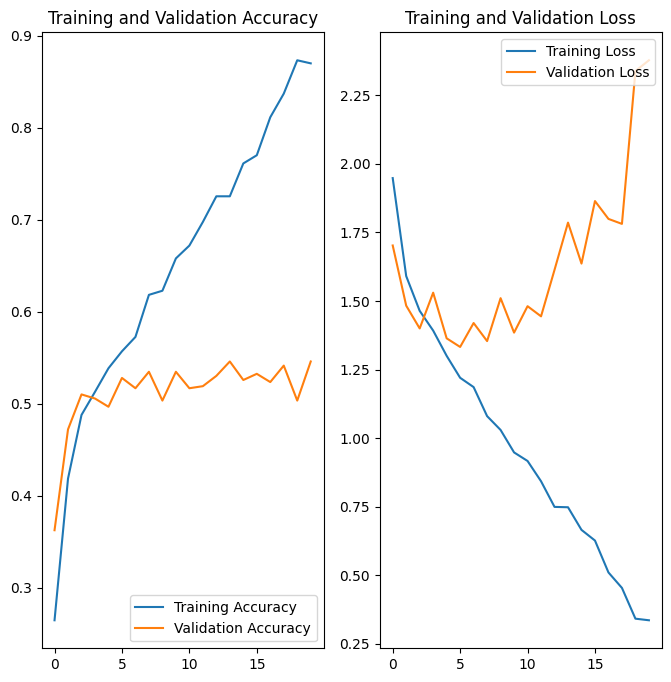

In [26]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations for MODEL1

1. We are getting a good training accuracy 88% but the validation accuracy is quite low ranging in 50's. This is clear case of overfitting.
2. Loss is close to 0.30608 for final epoch
2. We will try to drop some samples randomly to avoid overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Actual Class basal cell carcinoma
Predictive Class dermatofibroma


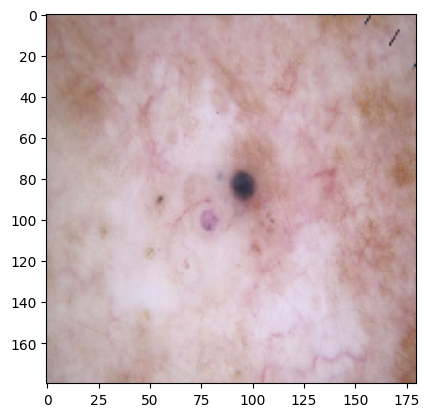

In [27]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model1.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

#### We see the prediction is wrong here test image is from Class Carcinoma but prediction says Dermatofibroma

### MODEL2


#### 1. Let's use an augmenation layer to tackle overfitting
#### 2. To avoid overfitting let's use a dropout layer


In [31]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [37]:
#CNN Model Architecture 2
# Data Augmentation Layer
augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

#Sequential allows you to create models layer-by-layer
model2 = Sequential()
model2.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
model2.add(augmentation) # Augmentation layer

#1st Convolutional layer
model2.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd Convolutional layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Convolutional layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(64,activation='relu'))

# Adding dropouts
model2.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
model2.add(layers.Dense(len(class_names),activation='softmax'))

model2.summary()



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [38]:
### Todo, choose an appropirate optimiser and loss function
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [39]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1783 - loss: 2.2393 - val_accuracy: 0.2304 - val_loss: 1.9119
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2820 - loss: 1.9628 - val_accuracy: 0.3154 - val_loss: 1.8248
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3454 - loss: 1.8034 - val_accuracy: 0.4161 - val_loss: 1.6501
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4087 - loss: 1.6748 - val_accuracy: 0.4765 - val_loss: 1.5809
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4091 - loss: 1.6582 - val_accuracy: 0.4139 - val_loss: 1.6229
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4563 - loss: 1.5669 - val_accuracy: 0.4765 - val_loss: 1.5181
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4892 - loss: 1.4721 - val_accuracy: 0.5011 - val_loss: 1.4729
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5013 - loss: 1.4240 - val_accuracy: 0.5123 - val_loss:

### Visualizing the results

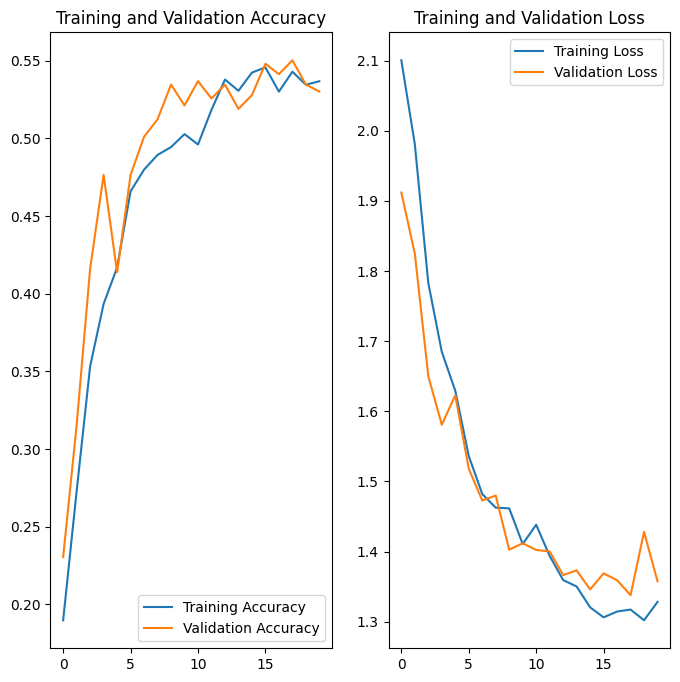

In [40]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We see the overfitting is reduced but the train accuracy has come down to ~55 which is not good.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Axes: xlabel='No. of Image', ylabel='Class'>

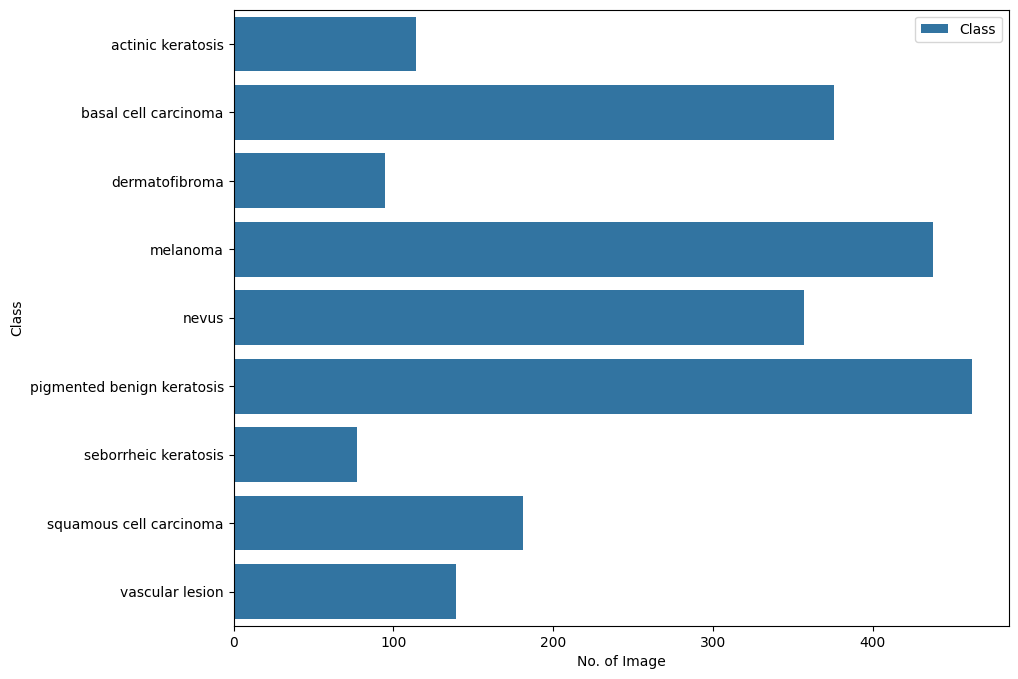

In [41]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Findings here:
#### - Class which has the least number of samples - seborrheic keratosis
#### - Classes which dominate the data in terms proportionate number of samples - pigmented benign keratosis and melanoma


In [54]:
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,actinic keratosis
1,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,actinic keratosis
2,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,actinic keratosis
3,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,actinic keratosis
4,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,vascular lesion
2235,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,vascular lesion
2236,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,vascular lesion
2237,/content/drive/MyDrive/Melonoma_Assignmnet/Dat...,vascular lesion


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [42]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
# Before doing this let's create another folder for datasets
!unzip "/content/drive/MyDrive/Melonoma_Assignmnet/CNN_assignment.zip" -d "/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2"

Archive:  /content/drive/MyDrive/Melonoma_Assignmnet/CNN_assignment.zip
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer 

In [44]:
# Defining the path for train and test images
data_dir_train2 = pathlib.Path("/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test2 = pathlib.Path("/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [45]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train2 = len(list(data_dir_train2.glob('*/*.jpg')))
print(image_count_train2)

#Test Image count
image_count_test2 = len(list(data_dir_test2.glob('*/*.jpg')))
print(image_count_test2)

2239
118


In [46]:
path_to_training_dataset=path_to_training_dataset=pathlib.Path("/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C80E6EAABF0>: 100%|██████████| 500/500 [00:27<00:00, 18.20 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C805C4D9450>: 100%|██████████| 500/500 [00:25<00:00, 19.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C8048BF1210>: 100%|██████████| 500/500 [00:27<00:00, 18.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C805D1219C0>: 100%|██████████| 500/500 [02:04<00:00,  4.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7C8048AFD9C0>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C805D074520>: 100%|██████████| 500/500 [00:25<00:00, 19.39 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C804C4E6620>: 100%|██████████| 500/500 [00:54<00:00,  9.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C8048B1BAF0>: 100%|██████████| 500/500 [00:25<00:00, 19.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C8048C5F4F0>: 100%|██████████| 500/500 [00:28<00:00, 17.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
image_count_train2_1 = len(list(data_dir_train2.glob('*/output/*.jpg')))
print(image_count_train2_1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [51]:
path_list_new = [x for x in glob(os.path.join(data_dir_train2, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_725d9a7d-d0a7-4cbc-8e3e-0c3684e24c3b.jpg',
 '/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_a61bfe06-8707-4c44-996e-13c2c534c204.jpg',
 '/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_f98c18b3-215d-4de6-bf2f-95241401aa25.jpg',
 '/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_3df4d82e-b90c-4374-8530-14e2d42202fc.jpg',
 '/content/drive/MyDrive/Melonoma_Assignmnet/Datasets2/Skin 

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train2, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [52]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [56]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [57]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [59]:
# train dataset
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train2, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [60]:
# validation dataset
val_ds2 =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train2,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### MODEL3

In [61]:
## CNN Architecture -3

#Sequential allows you to create models layer-by-layer
model3 = Sequential()

model3.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

##1st Convolutional layer
model3.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

##2nd Convolutional layer
model3.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Convolutional layer
model3.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model3.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(64,activation='relu'))

#Dropout layer with 12% Fraction of the input units to drop.
model3.add(layers.Dropout(0.12))

#Dense Layer with softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,633 (6.34 MB)

 Trainable params: 1,662,633 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile your model (Choose optimizer and loss function appropriately)

In [62]:
### Todo, choose an appropirate optimiser and loss function
model3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [63]:
epochs = 30
history3 = model3.fit(
  train_ds2,
  validation_data=val_ds2,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.2205 - loss: 2.0724 - val_accuracy: 0.4083 - val_loss: 1.5520
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.4079 - loss: 1.5599 - val_accuracy: 0.4759 - val_loss: 1.3904
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.4889 - loss: 1.3682 - val_accuracy: 0.4766 - val_loss: 1.3560
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.5288 - loss: 1.2618 - val_accuracy: 0.5687 - val_loss: 1.1656
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.5819 - loss: 1.1042 - val_accuracy: 0.5991 - val_loss: 1.0422
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6250 - loss: 0.9941 - val_accuracy: 0.6303 - val_loss: 0.9814
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.6884 - loss: 0.8616 - val_accuracy: 0.6674 - val_loss: 0.9225
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7018 - loss: 0.7986 - val_accu

#### Visualize the model results

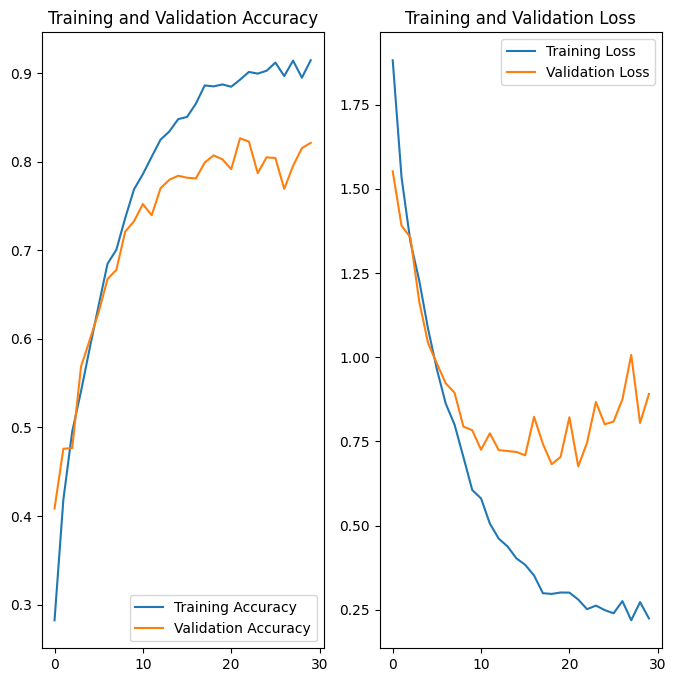

In [64]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Observation



#### 1. For Final model we see train accuracy is ~90 and validation accuracy is ~81
#### 2. Yes the Class rebalance did help as we can see with the validation accuracy
#### 3. We can say we have minimized the overfitting and underfitting greatly from the first model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


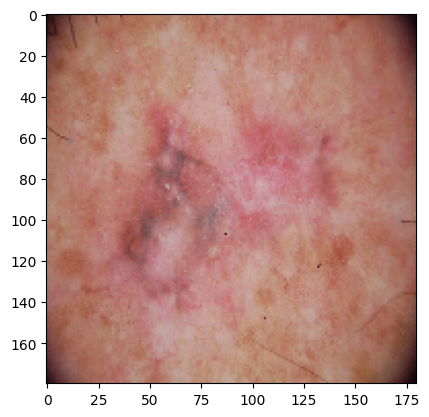

In [69]:
from glob import glob
Test_image_path = os.path.join(data_dir_test2, class_names[6], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )